# 5. Downstream Analyses of Factor Loadings

Here we use the loadings obtained with Tensor-cell2cell for each element in their respective dimensions (contexts, ligand-receptor pairs, sender cells, receiver cells). These loadings represent the importance of each element in a given factor or latent pattern. We can use this information to gain more insights about the biological processes underlying each of the communication patterns.

In [1]:
library(liana, quietly = TRUE)

library(dplyr, quietly = TRUE)
library(tibble, quietly = TRUE)

library(patchwork, quietly = TRUE)
library(ggplot2, quietly = TRUE)

library(purrr, quietly = TRUE)
library(forcats, quietly = TRUE)
library(tidyr, quietly = TRUE)
library(rstatix, quietly = TRUE)
library(ggpubr, quietly = TRUE)

library(reticulate, quietly = TRUE)
use_condaenv('ccc_protocols')
c2c <- reticulate::import(module = "cell2cell")


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘rstatix’


The following object is masked from ‘package:stats’:

    filter




## Directories

In [2]:
output_folder <- file.path('..', '..', 'data', 'tc2c-outputs')
data_path <- file.path('..', '..', 'data')

## Load Data

**Load the SingleCellExperiment object with the stored loadings obtained from the tensor factorization**

In [3]:
covid_data <- readRDS(file.path(data_path, 'covid_data_sce.rds'))

## Downstream Analyses

### Boxplots to statistically compare group of samples/contexts

The statistical test can be changed by modifying the parameters. An FDR correction is applied to the p-values. 

```statistical_test='t-test_ind'```

```pval_correction='benjamini-hochberg'```

In [4]:
sample_loadings <- liana::get_c2c_factors(covid_data,
                                          sample_col='sample_new',
                                          group_col='condition') %>%
                                          purrr::pluck("contexts") %>% 
                                          pivot_longer(-c("condition", "context"),
                                                names_to = "factor",
                                                values_to = "loadings") %>% 
                                          mutate(factor = factor(factor)) %>%
                                          mutate(factor = fct_relevel(factor, "Factor.10", after=9))

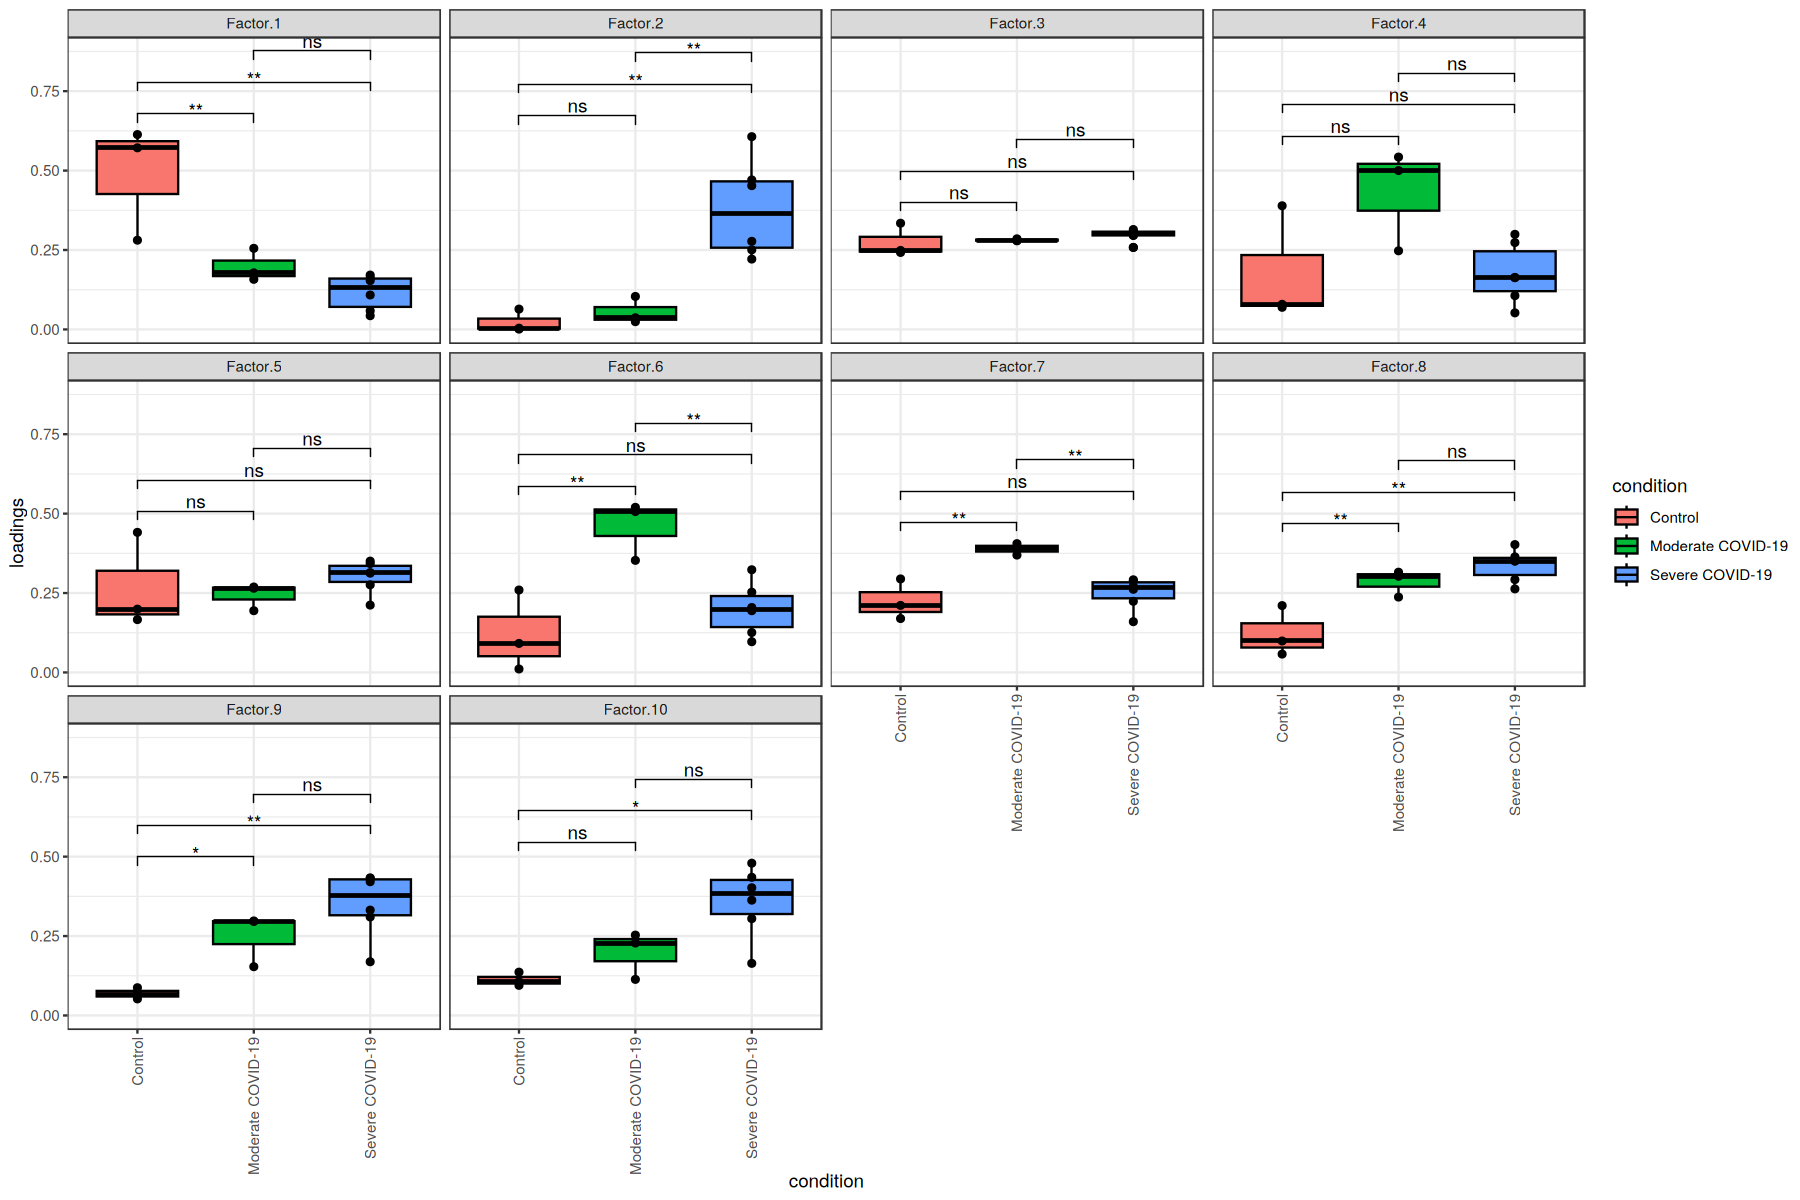

In [5]:
h_ = 10
w_ = 15
options(repr.plot.height=h_, repr.plot.width=w_)

# Do pairwise tests
pwc <- sample_loadings %>%
    group_by(factor) %>%
    rstatix::pairwise_t_test(
      loadings ~ condition, 
      p.adjust.method = "fdr"
      )

# plot
pwc <- pwc %>% add_xy_position(x = "condition")
ggboxplot(sample_loadings, x = "condition", y = "loadings", add = "point", fill="condition") +
    facet_wrap(~factor, ncol = 4) +
    stat_pvalue_manual(pwc) +
    theme_bw() + 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
    

Here, we see that the communication patterns (or context loadings) identified statistically significant patterns when comparing each pair of COVID-19 severities.

These factors thus represent differences in the ligand-receptor interactions as well as cell types participating in cell-cell communication among the different COVID-19 severities.

### Correlation between Context Loadings & COVID-19 Severity

We first define the ranking of the severity, where higher values represent the worst severity.

In [6]:
severity_rank<-function(x){
    if (x == 'Control'){
        ranking = 1
    }else if (x == 'Moderate COVID-19'){
        ranking = 2
    }else if (x == 'Severe COVID-19'){
        ranking = 3
    }
}

In [7]:
factors <- liana::get_c2c_factors(sce = covid_data,
                            sample_col = "sample_new",
                            group_col = "condition")
sev_rank <- data.frame(condition = factors$contexts$condition, 
                        severity.ranking = sapply(factors$contexts$condition, function(x) severity_rank(x)))
head(sev_rank)

,condition,severity.ranking
,<fct>,<dbl>
1,Control,1
2,Control,1
3,Control,1
4,Moderate COVID-19,2
5,Moderate COVID-19,2
6,Moderate COVID-19,2


Number of factors from the tensor decomposition

In [8]:
nfactors <- dim(factors$contexts %>% dplyr::select(starts_with("Factor")))[[2]]

**Spearman correlation**

In [9]:
for (i in 1:nfactors){
    factor <- paste0('Factor.', i)
    suppressWarnings({
        s.cor<-cor.test(factors$contexts[[factor]], sev_rank$severity.ranking, 
            method = 'spearman')        
    })

    s.r<-format(round(s.cor$estimate[['rho']], 2), nsmall = 2)
    s.p<-format(round(s.cor$p.value, 3), nsmall = 3)
    print(paste0(factor, ' has a Spearman correlation of ', s.r, 
                 ' with an associated p-value of ', s.p))
    
}

[1] "Factor.1 has a Spearman correlation of -0.85 with an associated p-value of 0.000"
[1] "Factor.2 has a Spearman correlation of 0.88 with an associated p-value of 0.000"
[1] "Factor.3 has a Spearman correlation of 0.41 with an associated p-value of 0.186"
[1] "Factor.4 has a Spearman correlation of -0.10 with an associated p-value of 0.751"
[1] "Factor.5 has a Spearman correlation of 0.42 with an associated p-value of 0.173"
[1] "Factor.6 has a Spearman correlation of 0.02 with an associated p-value of 0.944"
[1] "Factor.7 has a Spearman correlation of -0.15 with an associated p-value of 0.646"
[1] "Factor.8 has a Spearman correlation of 0.79 with an associated p-value of 0.002"
[1] "Factor.9 has a Spearman correlation of 0.85 with an associated p-value of 0.000"
[1] "Factor.10 has a Spearman correlation of 0.83 with an associated p-value of 0.001"


### Heatmaps

**Cluster samples/contexts by their importance across factors**

Here we provide a example on clustering samples given their respective loadings, colored by category of COVID-19 condition:

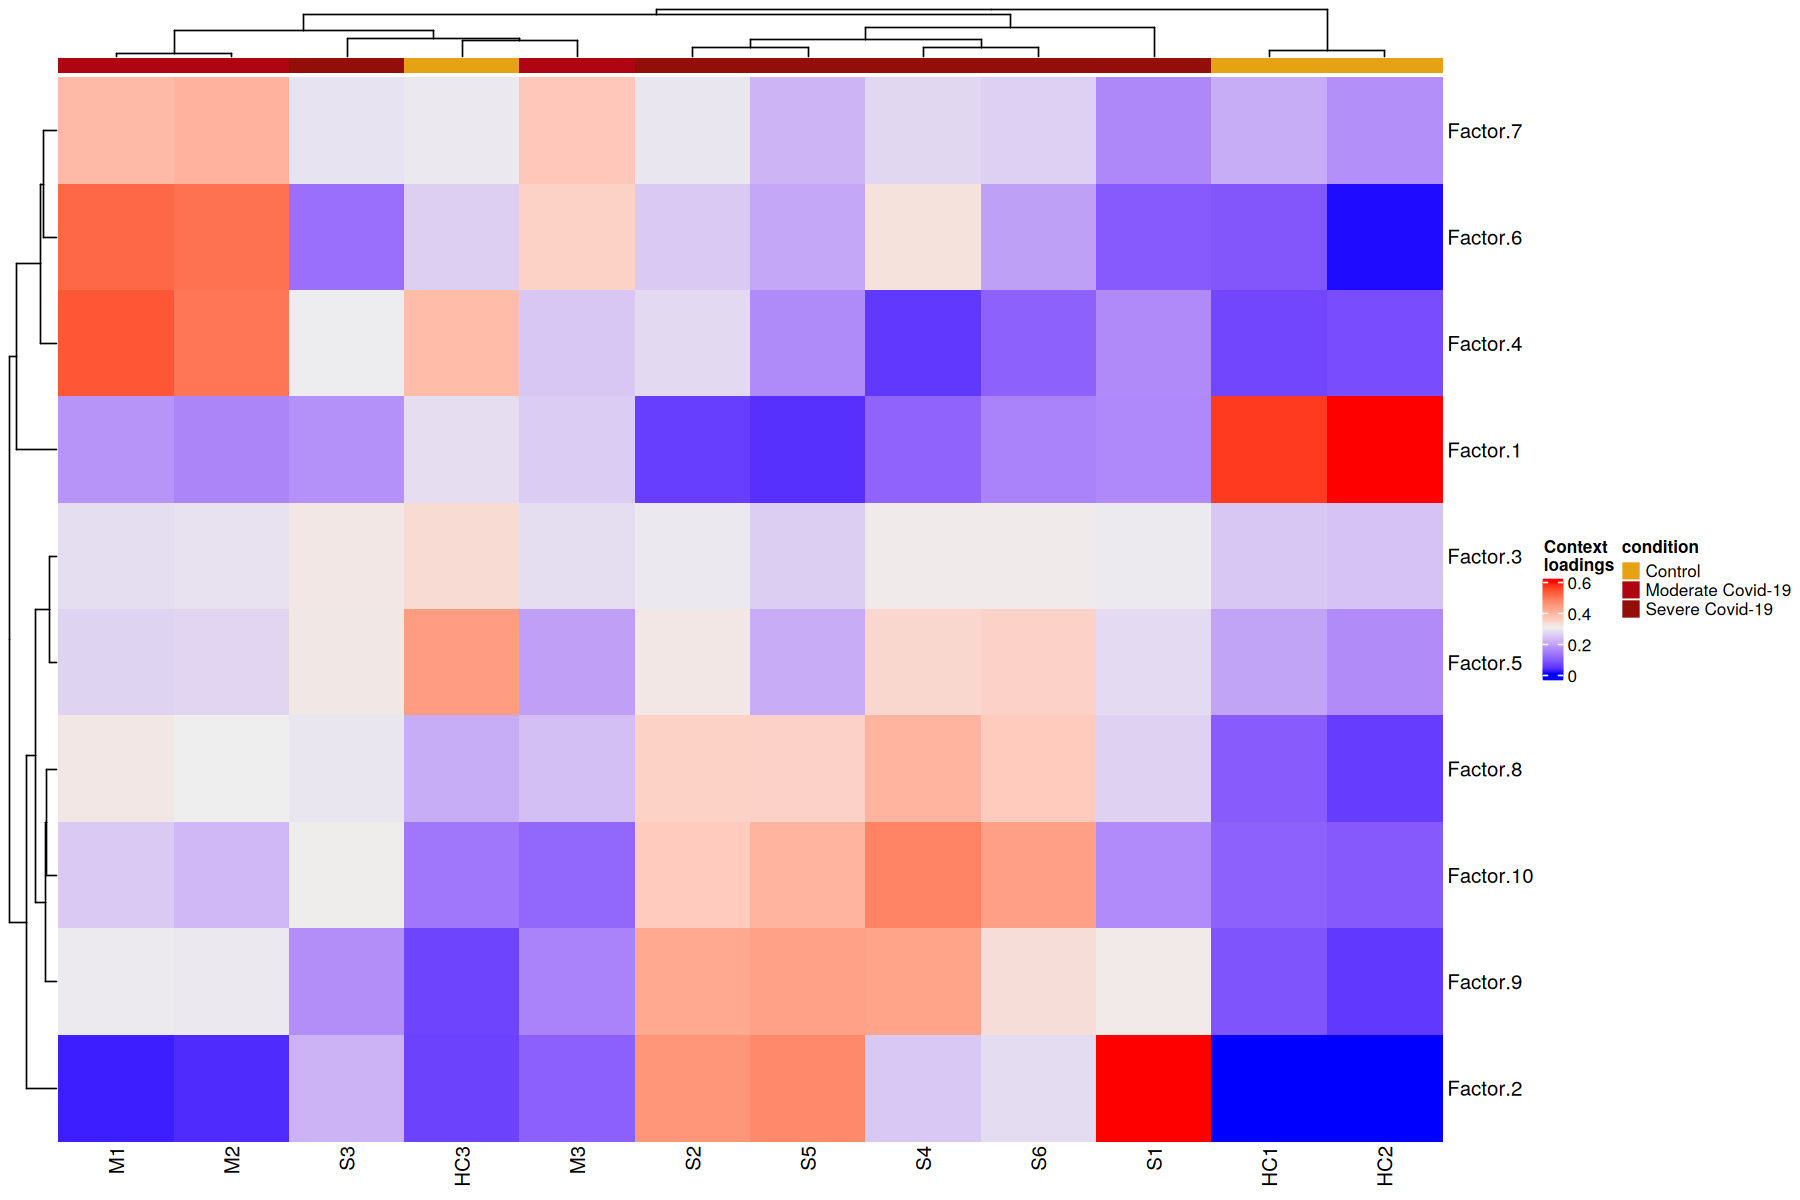

In [10]:
liana::plot_context_heat(sce = covid_data,
                sample_col = "sample_new",
                group_col = "condition")

Here patients are grouped by the importance that each communication pattern (factor) has in relation to the other patients. This captures combinations of related communication patterns that explain similarities and differences at a sample-specific resolution. In this case the differences are reflected with an almost perfect clustering by COVID-19 severity, where moderate cases are more similar to control cases.

**Cluster LR pairs by their importance across factors**

To consider important LR pairs in at least one factor, we can set a threshold to filter for the top n (fraction or number) of LR pairs. This value can be obtained in the way that user thinks is pertinent. Here we use ```n=05``` to filter for the top 5 LR pairs <span style='color:red'> per factor

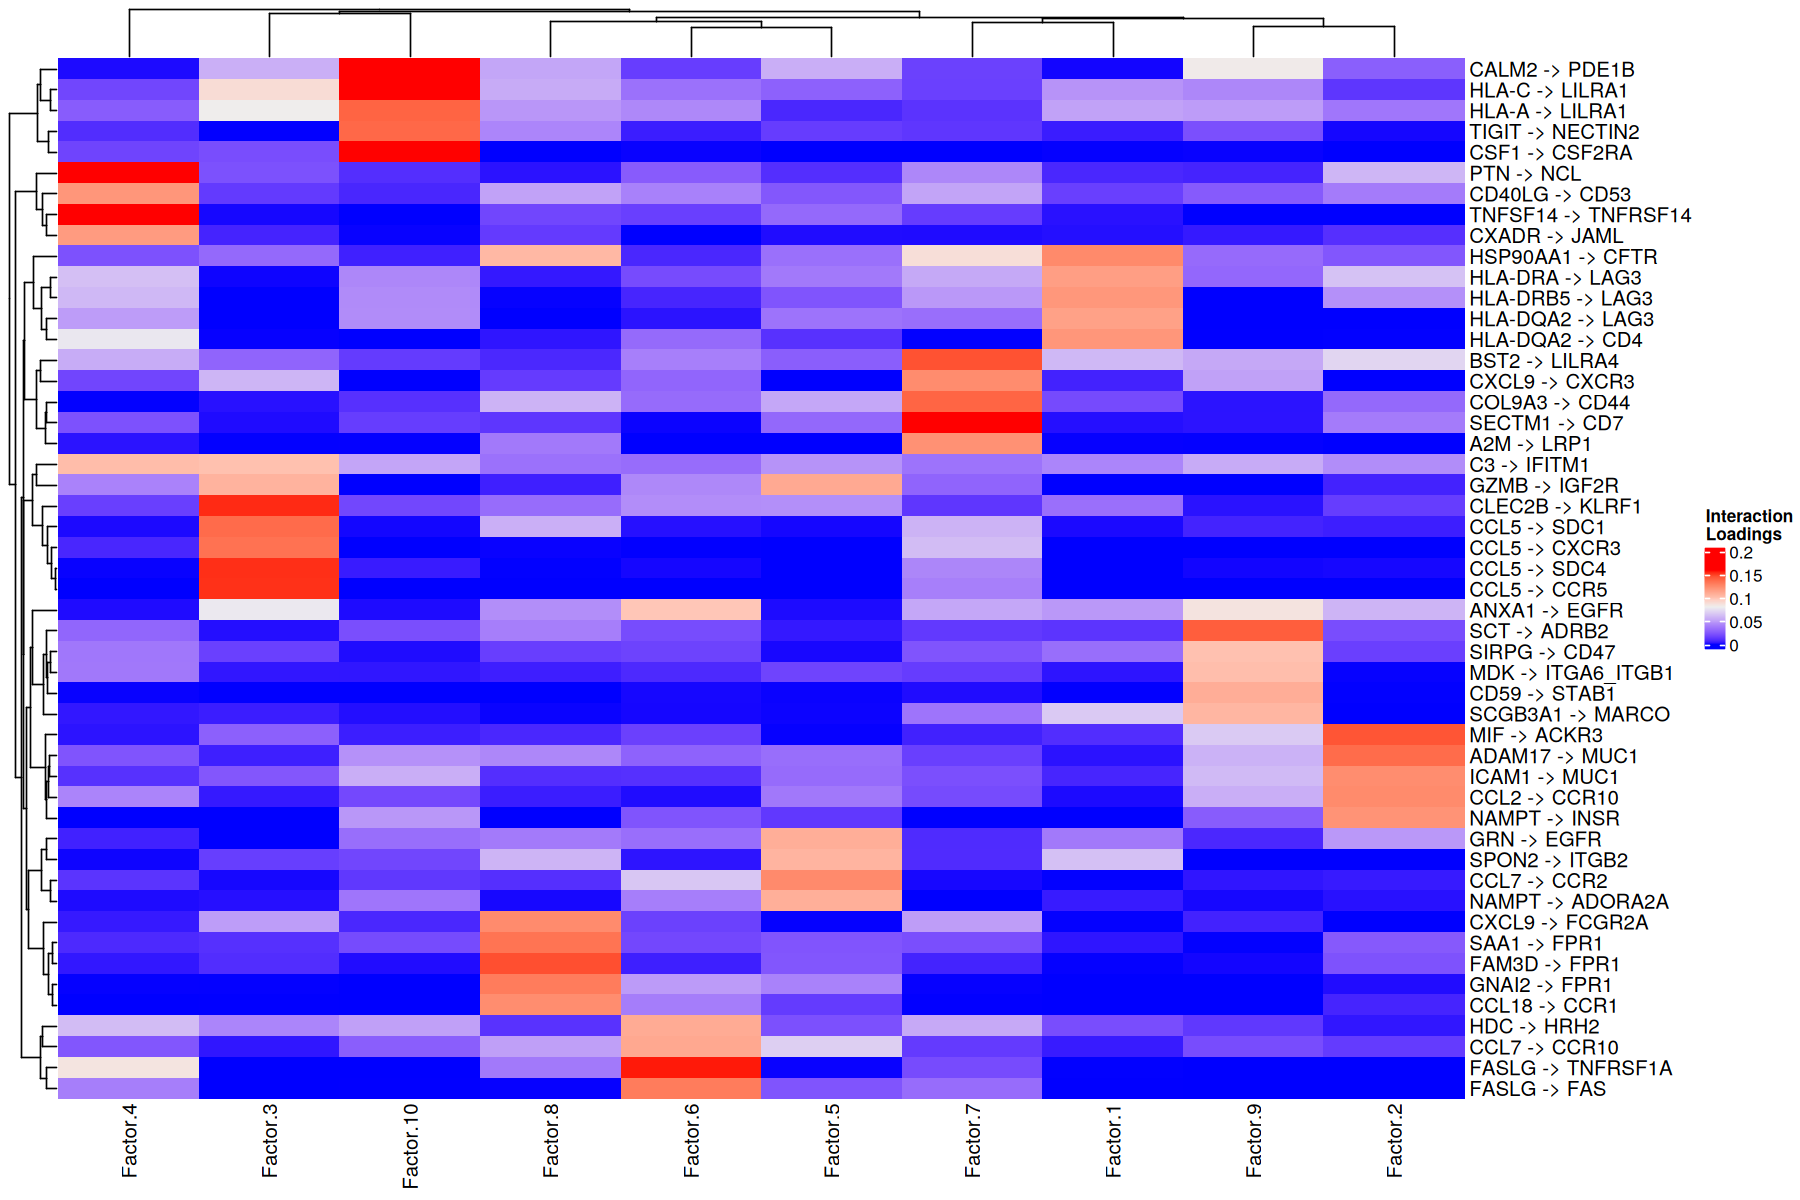

In [11]:
liana::plot_lr_heatmap(sce = covid_data,  n = 5)

In this case, LR pairs are grouped according to how important they for one factor versus the others. This can give an idea of the molecular mechanisms that are crucial in each communication pattern.

**Cluster sender-receiver pairs for an specific factor**

Factor 8 is associated with COVID-19 cases (see boxplots). Thus, it would be interesting to determine the cellular interactions underlying this communicatino pattern. To do so, we define its Loading Product between senders and receiver cells (outer product of loadings for that factor), which represents the joint importance of the cell-cell pair:

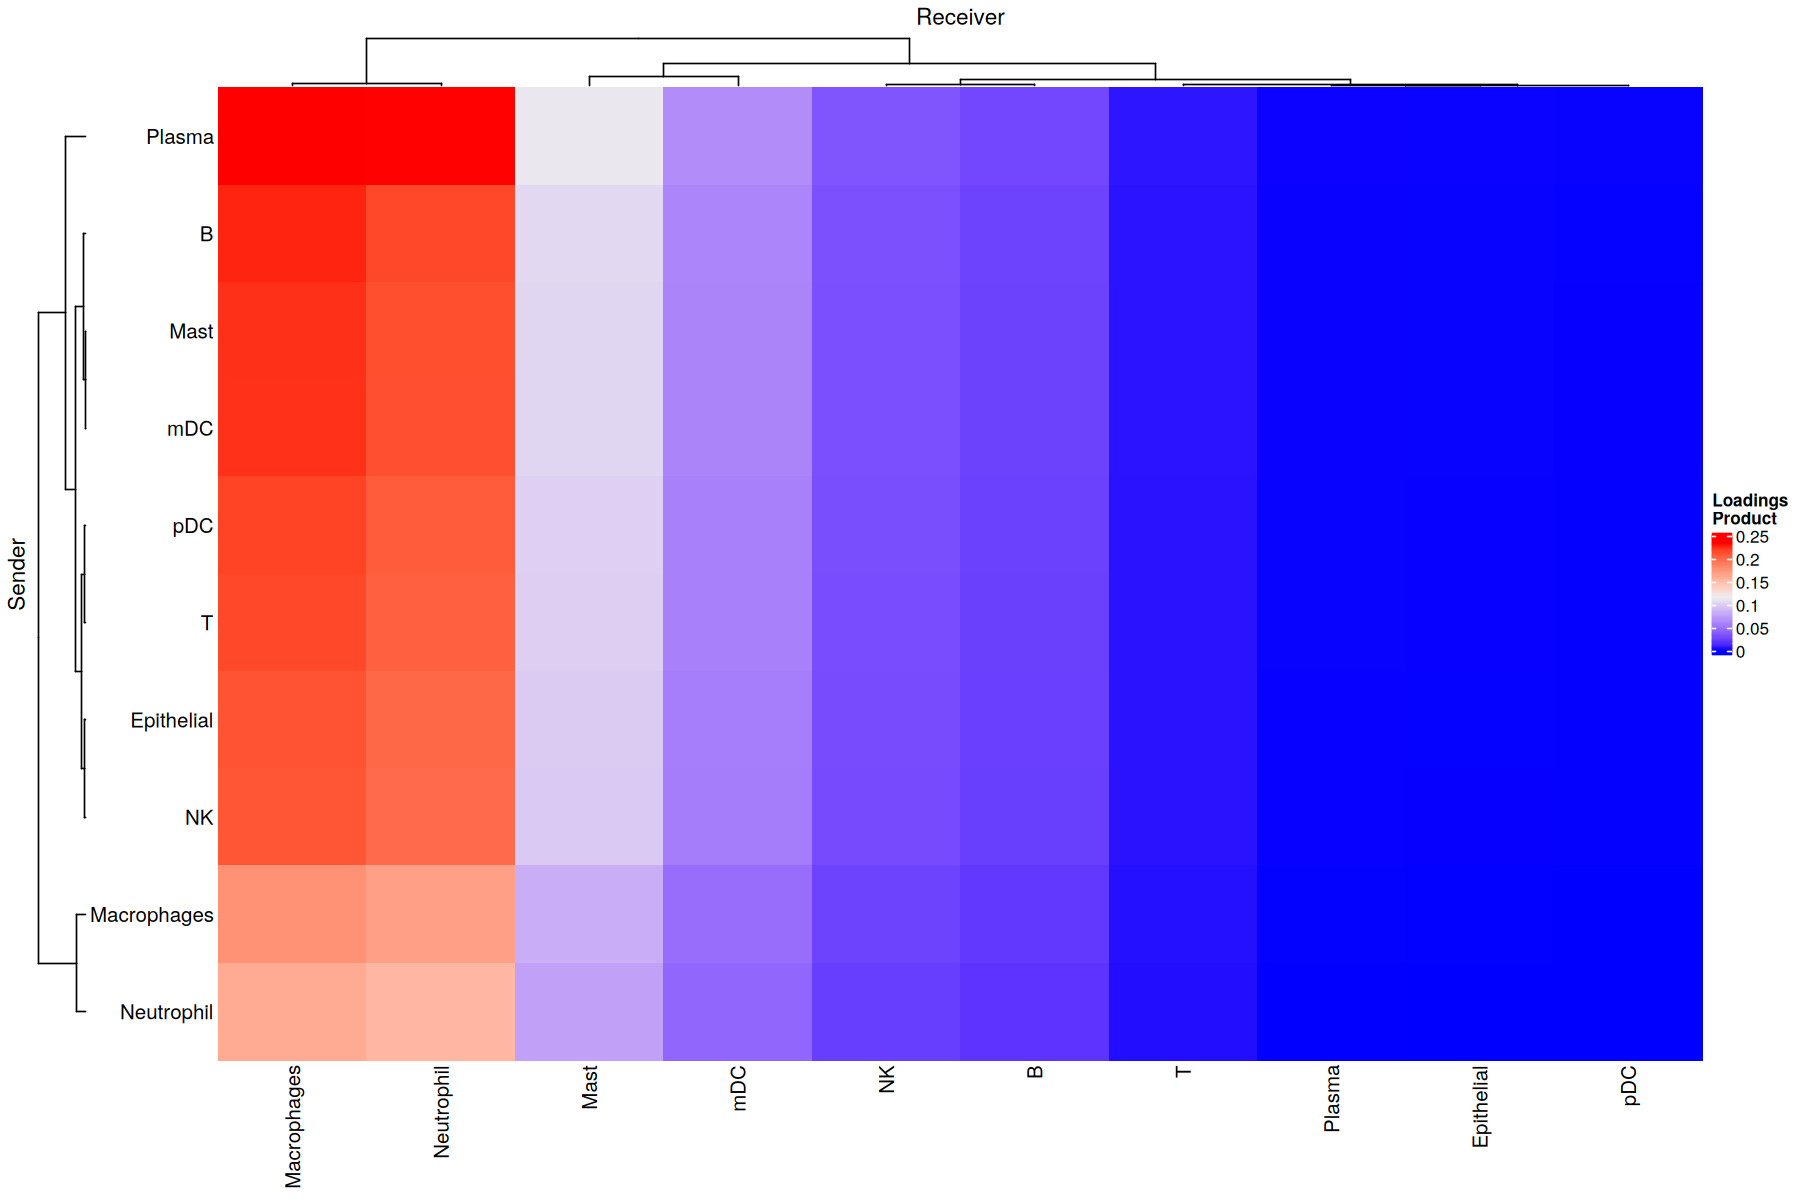

In [12]:
selected_factor <- 'Factor.8'
liana::plot_c2c_cells(sce = covid_data,
                   factor_of_int = selected_factor,
                   name = "Loadings \nProduct")

### Overall CCI potential: Network visualization of sender-receiver cell pairs

An interaction network can be created for each factor by using the loading product between sender and receiver cells. First we need to choose a threshold to indicate what pair of cells are interacting. To do so, we need to get all the outer products between the loadings for the sender and receiver cells dimensions across all factors.

In [13]:
head(factors[['interactions']])

lr,Factor.1,Factor.2,Factor.3,Factor.4,Factor.5,Factor.6,Factor.7,Factor.8,Factor.9,Factor.10
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A2M^LRP1,2.014718e-04,6.177029e-07,0.0001018409,2.616977e-03,1.016893e-06,5.631589e-07,1.216602e-01,3.608764e-02,1.469622e-04,1.185005e-04
ACTR2^ADRB2,3.939710e-02,3.842080e-02,0.0141220530,4.564203e-02,1.393886e-02,3.178997e-02,1.182422e-02,1.927887e-02,2.016811e-05,1.158559e-08
ACTR2^LDLR,1.093640e-04,1.604342e-16,0.0116169443,2.514870e-02,4.178628e-10,3.704964e-02,2.194405e-10,1.038034e-09,1.593195e-03,6.626642e-02
ADAM10^AXL,4.680507e-05,1.702355e-14,0.0015532948,3.183815e-02,1.170693e-02,4.584032e-02,5.565283e-02,8.909291e-08,1.652256e-11,8.912689e-11
ADAM10^CADM1,2.598824e-04,3.258244e-08,0.0011500110,4.352961e-10,3.441869e-02,1.577997e-04,4.419620e-04,1.123850e-03,1.777034e-05,1.144090e-06
ADAM10^CD44,5.699971e-03,2.898187e-02,0.0288283825,6.858978e-03,6.697052e-02,1.096958e-02,1.019256e-01,5.999368e-02,3.157115e-02,8.152719e-03


In [14]:
# format for use with cell2cell
format_py_df<-function(df){
    df<-df %>% 
    as.data.frame() %>% 
    textshape::column_to_rownames() %>%
    select(-contains("condition"))
    
    return(df)
}
py_factors<-unname(lapply(factors, function(df) format_py_df(df)))
py_factors = reticulate::py_dict(keys = names(factors), values = py_factors)

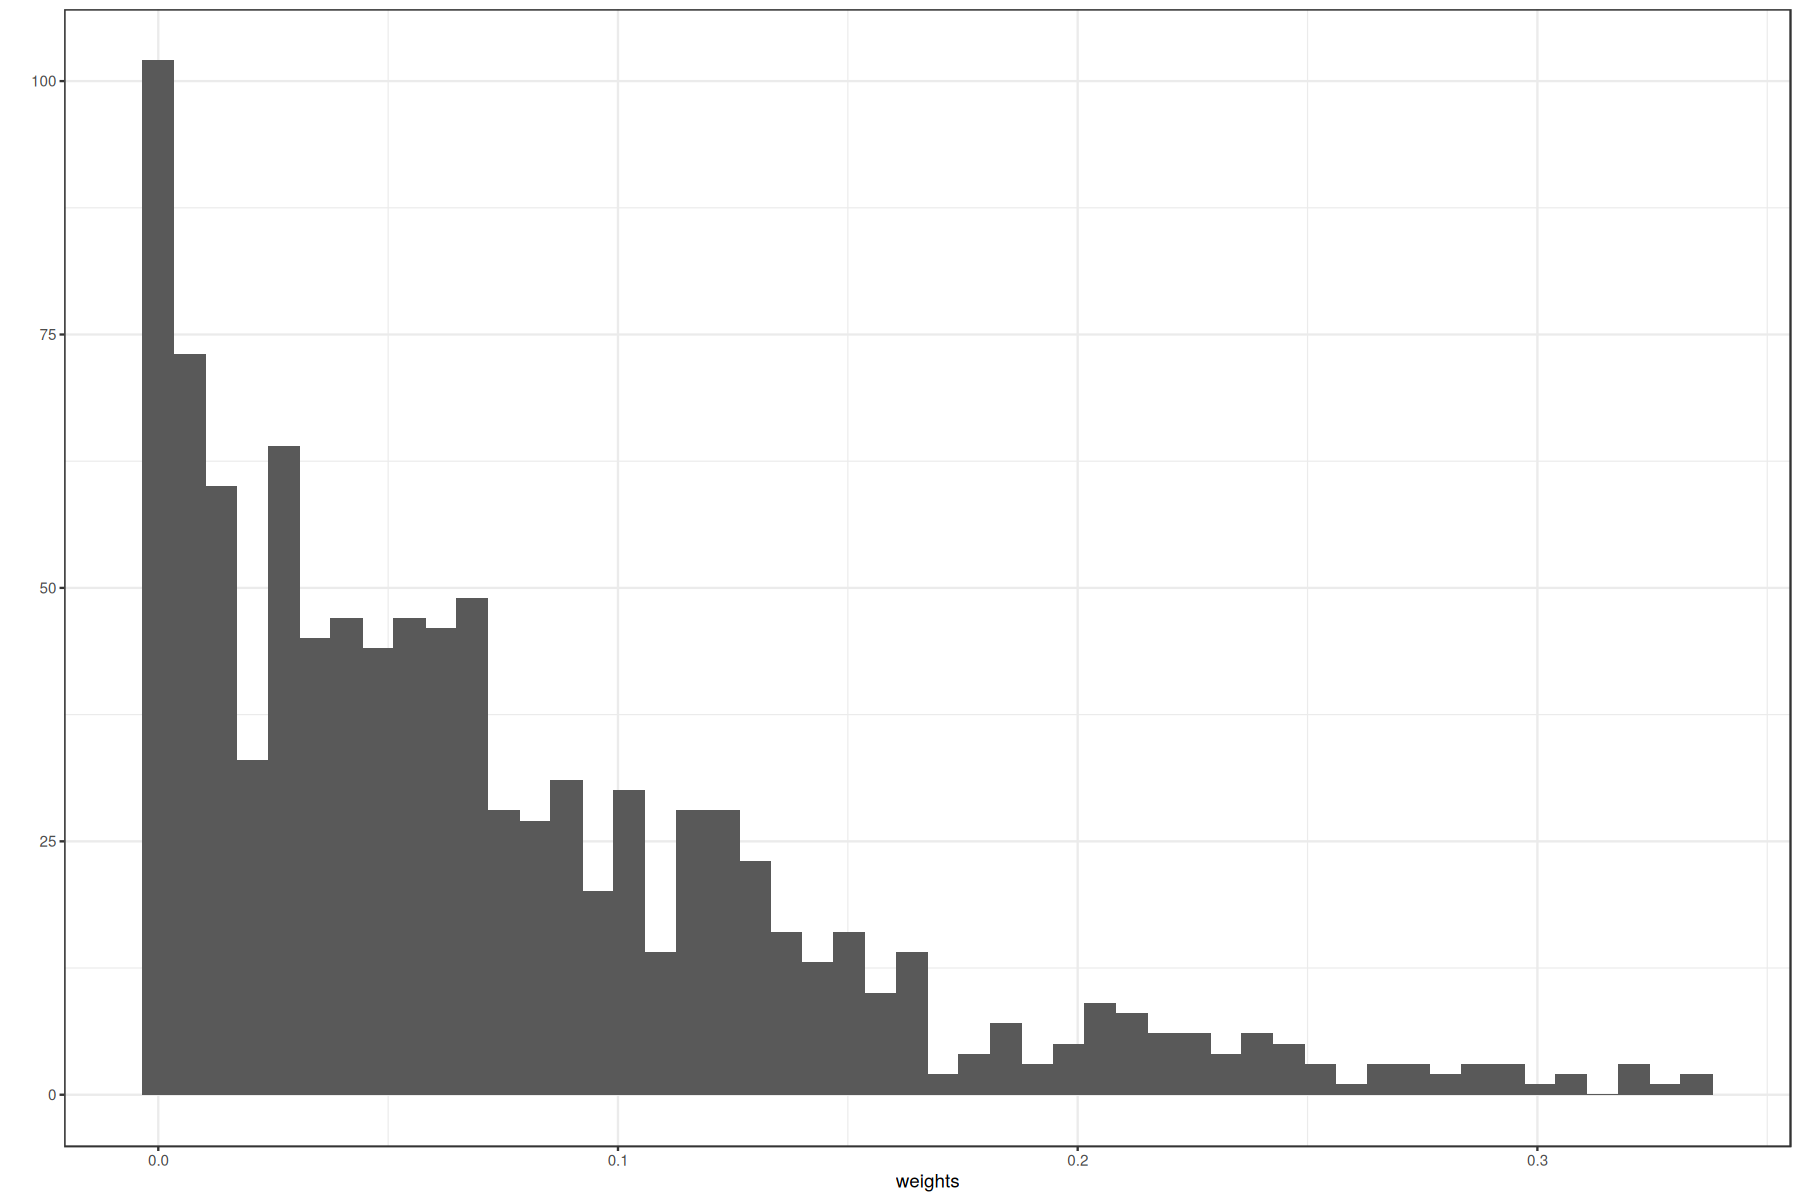

In [15]:
# Get all outer products as adjacency matrices, one per factor
networks <- c2c$analysis$tensor_downstream$get_factor_specific_ccc_networks(py_factors,
                                                                            sender_label = 'senders',
                                                                            receiver_label = 'receivers')

# Then, flatten the adjacency matrices
network_by_factors = c2c$analysis$tensor_downstream$flatten_factor_ccc_networks(networks, orderby='receivers')

# And we can plot the distributions of the weights for each factor-specific network
ggplot(data.frame(weights = unlist(unname(as.vector(network_by_factors)))), aes(x=weights)) + 
geom_histogram(bins = 50) + theme_bw() + ylab('')


With this distribution we can set a reasonable threshold. We can also apply some mathematical methods to select one, as for example choosing a percentile. Here we set a threshold of 0.075.

In [16]:
threshold = 0.075

Then, we can plot all networks we are interested in:

In [17]:
c2c$plotting$ccc_networks_plot(py_factors,
                               included_factors=c('Factor.2', 'Factor.8', 'Factor.9'),
                               sender_label='senders', 
                               receiver_label='receivers',
                               ccc_threshold=threshold, # Only important communication
                               nrows=as.integer(1), 
                               filename=file.path(data_path, 'tc2c-outputs', 'network_plot_05_r.png')
                              )

[[1]]
<Figure size 2400x800 with 3 Axes>

[[2]]
[[2]][[1]]
<Axes: title={'center': 'Factor.2'}>

[[2]][[2]]
<Axes: title={'center': 'Factor.8'}>

[[2]][[3]]
<Axes: title={'center': 'Factor.9'}>



![network_plot_05](../../data/tc2c-outputs/network_plot_05_r.png "Network Plot")

### Gini coefficients of the factor-specific cell-cell communication

The Gini coefficient quantifies the extent to which sender-receiver cell pairs differ within a factor according to their importance as measured by their loadings. Here it is use to measure the imbalance of communication for a given factor. In other words, it identifies whether a few cells are key for an identified pattern (low Gini coefficient) or whether the pattern corresponds to a general process that involves most of the cell types (high Gini coefficient). Gini coefficients range between [0, 1].

**Note that here we show ginis seperately for sender and receiver cell types per factor, while in Python we show the combined gini for sender and receiver cell types**

In [18]:
# Get loadings for source/sender Cell types
calculate_gini(factors$senders)

factor,gini
<chr>,<dbl>
Factor.1,0.2662005
Factor.10,0.1829162
Factor.2,0.1913923
Factor.3,0.4460056
Factor.4,0.4506584
Factor.5,0.6984962
Factor.6,0.6161417
Factor.7,0.2631348
Factor.8,0.0631097


In [19]:
# Get loadings for source/sender Cell types
calculate_gini(factors$receiver)

factor,gini
<chr>,<dbl>
Factor.1,0.08451066
Factor.10,0.47924770
Factor.2,0.10965274
Factor.3,0.13653756
Factor.4,0.09516597
Factor.5,0.14736680
Factor.6,0.10340692
Factor.7,0.50656809
Factor.8,0.69806214


For senders, we observe that the lowest Gini coefficient was obtained by Factor 2, which seems to have more balanced cell loadings. Similarly, for receivers, the lowest Gini coefficient is in Factor 10. For each of these factors respectively, senders and receivers are more similar or homogeneous.